<a href="https://colab.research.google.com/github/nmurillon/DeepLearningChallenge/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Deep Learning

Travail de Dorian Gravegeal et Nicolas Murillon



###Imports


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Ajouter les imports nécessaires
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###Variables globales

In [ ]:
num_epochs = 100
batch_size = 250

img_shape = (28,28,1)
img_size = img_shape[:2]

num_classes = 5
stop_freeze = 4


#Premier modèle
Dans un premier temps, nous avons cherché à faire un réseau CNN assez simple en s'inspirant de celui que nous avons vu en cours.
Pour cela il faut d'abord définir les fonctions permettant de charger les données d'entraînement et de validation.

##Données

Nous allons donc commencer par monter notre drive afin de récupérer le fichier zip contenant les images. Le drive nous permettra également de stocker nos résultats

In [ ]:
#On monte le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Copie du zip dans le stockage local de la vm
!cp /content/drive/MyDrive/DeepLearning/Data_Train_Valid.zip /content/sample_data/Data_Train_Valid.zip

In [ ]:
#unzip
!mkdir /content/sample_data/DeepLearning
!mkdir /content/sample_data/DeepLearning/sauve
!unzip -qq /content/sample_data/Data_Train_Valid.zip -d /content/sample_data/DeepLearning

In [ ]:
#on change le répertoire courant pour faciliter l'accès aux données
os.chdir('/content/sample_data/DeepLearning') 

On définit ensuite les classes dont nous avons avoir besoin, puis on lit les données grâce au module panda. Lors de la lecture des données, on précise que le type de données lu doit être convertit en chaîne de caractères afin de pouvoir utiliser un générateur (voir par la suite)

In [ ]:
classes = ["basket","eye","binoculars","rabbit","hand"]

train = pd.read_csv('train.csv', dtype="str")
valid = pd.read_csv('valid.csv', dtype="str")

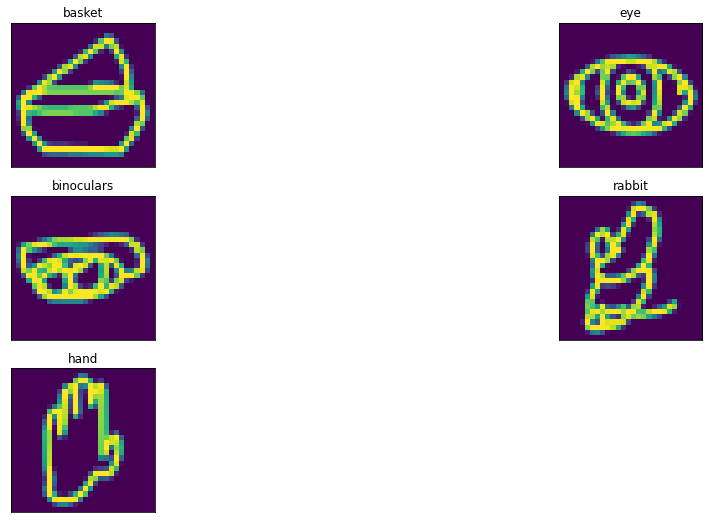

In [ ]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


On utilise également un ImageDataGenerator puisque ce dernier permet de charger les données grâce à un dataframe (obtenu grâce au module panda)

In [ ]:
#Utilisation d'un générateur pour pouvoir utiliser le dataframe fourni par panda
ImageGenerator = ImageDataGenerator(
    rescale = 1./255, 
)

train_generator = ImageGenerator.flow_from_dataframe(
    dataframe=train, # Données provenant de pandas pour l'entrainement
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=batch_size,
    validate_filenames=False, # Pas de vérification des fichiers pour gagner du temps
    shuffle=True, # En rendant aléatoire les données on augmente les chances d'avoir un lancement meilleur
    horizontal_flip=True
)

valid_generator = ImageGenerator.flow_from_dataframe(
    dataframe=valid, # Données provenant de pandas pour l'entrainement
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=batch_size,
    validate_filenames=False, # Pas de vérification des fichiers pour gagner du temps
    shuffle=True, # En rendant aléatoire les données on augmente les chances d'avoir un lancement meilleur
)

Found 75000 non-validated image filenames belonging to 5 classes.
Found 25000 non-validated image filenames belonging to 5 classes.


##Entraînement du réseau

On commence par définir la structure de notre réseau.

In [ ]:
def getModel(dropout=0.2, Conv2DActivation='relu', DenseActivation='relu', optimizer='adam', loss='categorical_crossentropy'):
   model = Sequential([
                    Input(shape=img_shape),
                    Conv2D(32,(3,3), activation=Conv2DActivation),
                    MaxPooling2D(),
                    Dropout(dropout),
                    Conv2D(64,(3,3), activation=Conv2DActivation),
                    MaxPooling2D(),
                    Dropout(dropout),
                    Flatten(),
                    Dense(1024, activation=DenseActivation),
                    Dropout(dropout),
                    Dense(5,activation="softmax")
        ])
   model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

   return model

In [ ]:
#Construction du modèle

model = getModel(dropout=0.5)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 64)         

On définit ensuite les callbacks que nous allons utiliser pour l'entraînement.
Le premier permet de sauvegarder le réseau chaque fois que le résultat obtenu est meilleur que le précédent. Nous avons également utilisé un deuxième callbacks permettant d'arrêter l'entraînement après un 10 epochs si la valeur de **val_loss** n'a pas diminué par rapport à la meilleur valeure obtenue auparavant.

On entraîne ensuite le modèle.

In [ ]:
# # Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("/content/sample_data/DeepLearning/sauve"):
    os.mkdir("/content/sample_data/DeepLearning/sauve")
    
checkpoint = ModelCheckpoint("/content/sample_data/DeepLearning/sauve/CNN-loss-{val_loss:.2f}-acc-{accuracy:.2f}-val_acc-{val_accuracy:.2f}.h5",
                                save_best_only=True,verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=10)
#Entrainement Data_generator

val_steps_epoch = np.ceil(valid_generator.samples / batch_size)

history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    validation_steps=val_steps_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.7605
Epoch 00001: val_loss improved from inf to 0.36740, saving model to /content/sample_data/DeepLearning/sauve/CNN-loss-0.37-acc-0.76-val_acc-0.88.h5
300/300 [==============================] - 59s 195ms/step - loss: 0.6771 - accuracy: 0.7605 - val_loss: 0.3674 - val_accuracy: 0.8831
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8609
Epoch 00002: val_loss improved from 0.36740 to 0.29383, saving model to /content/sample_data/DeepLearning/sauve/CNN-loss-0.29-acc-0.86-val_acc-0.91.h5
300/300 [==============================] - 59s 195ms/step - loss: 0.4217 - accuracy: 0.8609 - val_loss: 0.2938 - val_accuracy: 0.9098
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8827
Epoch 00003: val_loss improved from 0.29383 to 0.24243, saving model to /content/sample_data/DeepLearning/sauve/CNN-loss-0.24-acc-0.88-val_acc-

On affiche ensuite le résultat de l'apprentissage sous forme de graphe.

Dans notre cas, aucun sur-entraînement n'est apparu. Le modèle présenté ici est celui pour lequel nous avons obtenu les meilleurs résultats.

Nous avons essayé de faire varier les paramètres du réseaux tels que :
  - Dropout
  - Fonction d'Activation
  - Optimpizer

Sur tous les modèles que nous avons pu tester, la précision variait de 90% pour le pire des modèles à 95,5% pour le meilleur.

Au vu des résultats, nous avons gardé la configuration suivante:
  - Dropout : 0.5
  - Fonction d'Activation : Relu
  - Optimpizer : Adam

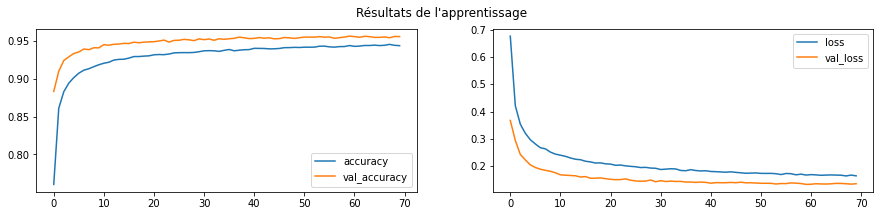

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle("Résultats de l'apprentissage")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.legend(['accuracy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['loss', 'val_loss'])
plt.savefig("training.png",dpi=100)

In [ ]:
!cp -R /content/sample_data/DeepLearning/sauve /content/drive/MyDrive/DeepLearning/

Pour finir, nous avons évalué notre réseau. Ce dernier nous permet d'obtenir une précision de 95,5%

In [ ]:
#Construction du meilleur modèle
model = getModel(0.5)
model.load_weights("/content/sample_data/DeepLearning/sauve/CNN-loss-0.13-acc-0.94-val_acc-0.96.h5") # TODO

# Evaluation du modèle
evaluation = model.evaluate(valid_generator, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

100/100 [==============================] - 15s 147ms/step - loss: 0.1325 - accuracy: 0.9553
Perte = 0.133, Précision = 0.955


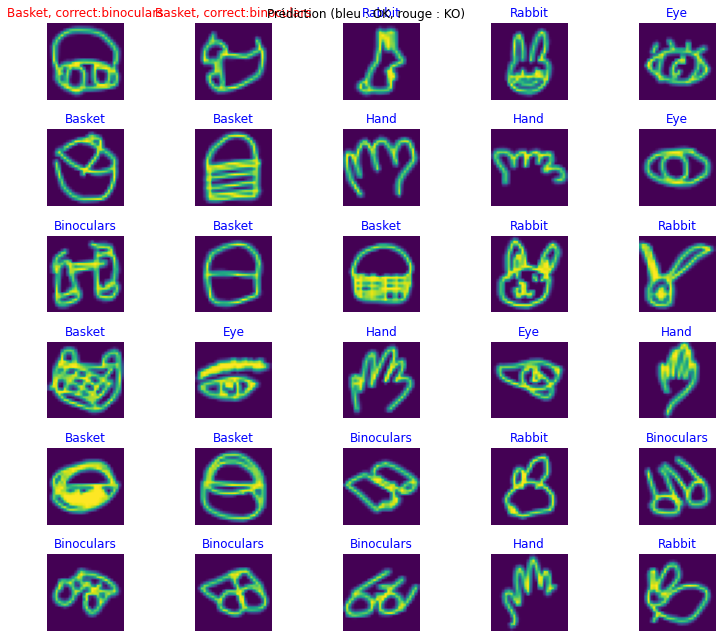

In [ ]:
# Quelques exemples de bonne / mauvaise classification

#With Data_generator
image_batch, label_batch = next(iter(valid_generator))
label = np.argmax(label_batch,axis=1)
label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n].reshape(28,28))
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)


#Deuxième modèle

Dans un second temps, nous avons essayé de faire du transfer Learning.

Nous avons alors essayé de charger des modèles existants tels que MobileNetV2.

Plusieurs problèmes se sont présentés à nous. En effet, les réseaux pré-entraînés n'acceptent pas d'images dont la taille est inférieure à 32x32 pixels. De plus, les images doivent être en RGB.

Ces contraintes nous obligent à utiliser un générateur afin de ne pas saturer la RAM.

Nous avons donc essayé d'utiliser le réseau MobileNetV2. Un autre problème est alors apparu, pour des images RGB de 224x224 pixels, les temps d'entraînement sont beaucoup plus longs que pour le réseau que nous avons présenté en première partie. En effet, pour ce dernier, le temps d'entraînement complet est de 45min à 1h, tandis que pour le modèle pré-entrainé, il faut environ 3min par epoch.

Par ailleurs, au vu des tests que nous avons fait, nous arrivons rapidement dans des situations de sur-entraînement pour un résultat moins bon que le premier modèle (environ 93% de réussite)

Nous avons donc abandonné cette piste

#Troisième modèle

Dans un troisième temps, nous nous sommes penchés sur l'augmentation des données. Le jeu de données fourni est assez conséquent mais nous avons essayé d'entraîner notre réseau sur un jeu de données encore plus grand.

Pour cela, nous avons récupéré l'ensemble des 5 catégories d'images sur quickdraw. Cela représente environ 160000 images pour chaque catégorie.

Le réseau choisi est le même que celui présenté dans la première partie et grâce à l'entraînement, nous obtenons une précision dépassant les 97%.

Détails à rajouter